Test the calculation of the HII mass of a galaxy from its H$\alpha$ emission

In [59]:
import numpy as np
import numpy.ma as ma

from astropy.table import Table
import astropy.constants as const
import astropy.units as u

import matplotlib.pyplot as plt

import sys

sys.path.insert(1, '/home/kelly/Documents/RotationCurves/spirals/')
from DRP_rotation_curve import extract_data

# Data

In [56]:
fits_dir = '/home/kelly/Documents/Data/SDSS/dr17/'

fits_filename = fits_dir + 'master_table_Halpha_BB_HI_H2_MxCG_R90_CMD_ZPG16R_SFR_MZ_phi.txt'

fits = Table.read(fits_filename, format='ascii.commented_header')

In [19]:
MANGA_FOLDER = '/home/kelly/Documents/Data/SDSS/dr17/manga/spectro/'

VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v3_1_1/3.1.0/HYB10-MILESHC-MASTARSSP/'

In [58]:
gal_ID = '8997-9102'

maps = extract_data(VEL_MAP_FOLDER, gal_ID, ['Ha_flux', 'Ha_flux_err'], dr=17)

plate, ifu = gal_ID.split('-')

fit_row = fits[(fits['MaNGA_plate'] == int(plate)) & (fits['MaNGA_IFU'] == int(ifu))]

In [90]:
mHa_flux = ma.array(maps['Ha_flux'], mask=maps['Ha_flux_mask'], dtype=np.float64)

# Calculate recombination rate for H

From [Badnell (2006)](https://ui.adsabs.harvard.edu/abs/2006ApJS..167..334B/abstract):
\begin{equation}
  \alpha (T) = A \left[ \sqrt{\frac{T}{T_0}} \left( 1 + \sqrt{\frac{T}{T_0}} \right)^{1 - B} \left( 1 + \sqrt{\frac{T}{T_1}} \right)^{1 + B} \right]^{-1}
\end{equation}

In [91]:
def alpha(T, A, B, T0, T1):
    '''
    Calculate the Case A recombination coefficient
    
    Units of alpha: cm^3 s^-1
    '''
    
    return A/(np.sqrt(T/T0)*(1 + np.sqrt(T/T0))**(1 - B)*(1 + np.sqrt(T/T1))**(1 + B))

In [92]:
# HII parameters are from '/home/kelly/Documents/Data/CHIANTI/h/h_2/h_2.rrparams'
A = 8.3180e-11
B = 0.74720
T0 = 2.9650e+00
T1 = 7.0010e+05

a_A_Hii = alpha(1E4, A, B, T0, T1)
a_A_Hii

4.1933023584895474e-13

This is for Case A recombinatin, which I don't think we want...

Instead, let's use the values given by Dan in ASTR 244:

In [93]:
hca_Ha = 3.54e-25 # erg cm^-3 s^-1
hca_Hb = 1.24e-25 # erg cm^-3 s^-1

# Calculate $M_{HII}$

In [94]:
def Np(hca, ne, I):
    '''
    Calculate the number density of protons integrated along the line of sight.
    
    
    PARAMETERS
    ==========
    
    hca : float
        hc*(alpha/lambda) for a given transition
        
        Units are erg cm^-3 s^-1
        
    ne : float
        Electron number density
        
        Units are cm^-3
    
    I : float or ndarray
        Observed emission line intensity
        
        Units are 10^-17 erg/s/cm^2/spaxel
    '''
    
    return 4*np.pi*I/(hca*ne)


def M_Hii(hca, I, ne=100):
    '''
    Calculate the HII mass observed in a given emission line
    
    
    PARAMETERS
    ==========
    
    hca : float
        hc*(alpha/lambda) for a given transition
        
        Units are erg cm^-3 s^-1
        
    ne : float
        Electron number density.  Default = 100 cm^-3
    
    I : float or ndarray
        Observed emission line intensity
        
        Units are 10^-17 erg/s/cm^2/spaxel
    '''
    
    return const.m_p * Np(hca, ne, I)

In [95]:
mMp_Hii_map = M_Hii(hca_Ha, mHa_flux) # This is the mass per unit area (cm^2) per spaxel

## Multiply by the area of each spaxel (in cm) to compute the total mass in protons in each spaxel

In [96]:
H0 = 100*u.km/u.s/u.Mpc

MANGA_SPAXEL_SIZE = 0.5*(1/60)*(1/60)*(np.pi/180)  # spaxel size (0.5") in radians

dist_to_galaxy = const.c*fit_row['NSA_redshift'][0]/H0

pix_scale_factor = dist_to_galaxy.to('cm')*np.tan(MANGA_SPAXEL_SIZE)
pix_scale_factor

<Quantity 7.30538661e+20 cm>

In [98]:
mM_Hii_map = mMp_Hii_map*pix_scale_factor.value*pix_scale_factor.value

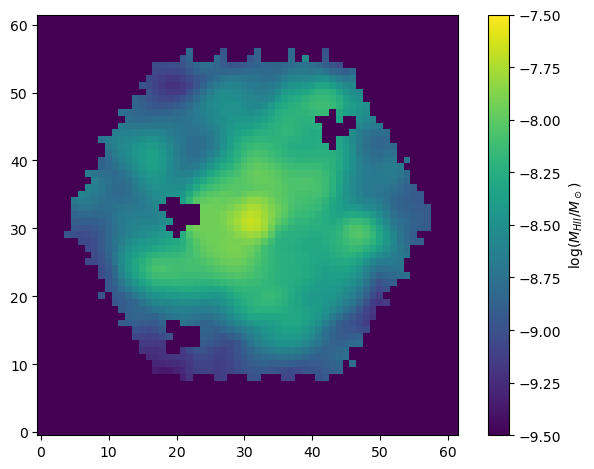

In [110]:
plt.figure(tight_layout=True)

plt.imshow(ma.log10(mM_Hii_map*1e-17/const.M_sun), origin='lower', vmin=-9.5, vmax=-7.5)

plt.colorbar(label="log($M_{HII}/M_\odot$)");